In [1]:
# Start ferret
import pyferret
import numpy as np
pyferret.start(quiet=True)


True

In [2]:
# Load the data set and store as a Python variable
# Python dictionaries are a type of variable that
# stores the data along with its metadata.
(error_value, error_message) = pyferret.run('use /home/jovyan/data/1_mesh_mask.nc')
glamt_dict = pyferret.getdata('glamt',False)
gphit_dict = pyferret.getdata('gphit',False)

e1t_dict = pyferret.getdata('e1t',False)
e2t_dict = pyferret.getdata('e2t',False)

# The "keys" are the names of the entries in the
# dictionary - its pieces.
glamt_dict.keys()

dict_keys(['title', 'data', 'missing_value', 'data_unit', 'axis_types', 'axis_names', 'axis_units', 'axis_coords'])

In [3]:
# Get data directly from the dictionary object (which
# includes metadata) and squeeze out unnecessary
# index places.
glamt = np.squeeze(glamt_dict['data'])
gphit = np.squeeze(gphit_dict['data'])

e1t = np.squeeze(e1t_dict['data'])
e2t = np.squeeze(e2t_dict['data'])

# Get the sizes of the arrays.
imt,jmt = np.shape(glamt)

imt,jmt

(1784, 1719)

In [4]:
# Need to rotate the array to plot North upward
# Experiments with this suggest that it doesn't
# work as I initially expected.
# Need to do more experiments.
#glamt = np.reshape(glamt,(jmt,-1), order='C')
#gphit = np.reshape(gphit,(jmt,-1), order='C')


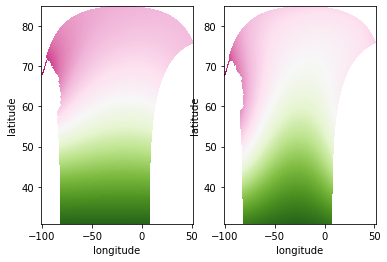

In [5]:
# Make a plot to verify that data have been loaded
# Using pcolormesh is good because it explicitly
# requires the pixel locations rather than implicit
# pixel locations with an image plotting tool.
import matplotlib.pyplot as plt
cmap = plt.get_cmap('PiYG')
# Use tuple unpacking to list the axes.
# See: https://matplotlib.org/3.1.0/gallery/subplots_axes_and_figures/subplots_demo.html
fig, axs = plt.subplots(ncols=2)
#axs[0].pcolormesh(glamt[1:imt-2,1:jmt-2],gphit[1:imt-2,1:jmt-2],glamt[1:imt-2,1:jmt-2], cmap=cmap)
#axs[1].pcolormesh(glamt[1:imt-2,1:jmt-2],gphit[1:imt-2,1:jmt-2],gphit[1:imt-2,1:jmt-2], cmap=cmap)
axs[0].pcolormesh(glamt[1:imt-2,1:jmt-2],gphit[1:imt-2,1:jmt-2],e1t[1:imt-2,1:jmt-2], cmap=cmap)
axs[1].pcolormesh(glamt[1:imt-2,1:jmt-2],gphit[1:imt-2,1:jmt-2],e2t[1:imt-2,1:jmt-2], cmap=cmap)

for ax in axs:
    ax.set(xlabel='longitude',ylabel='latitude')

plt.show()


# To do:

1. load grids
2. load grid spacings
3. load SSH
4. figure out downscaling
5. element-by-element mult spacings by area
6. find average and store


In [ ]:
# Initialize array to hold output

In [6]:
# Load SSH data
(error_value, error_message) = pyferret.run('use /home/jovyan/data/V20_1948_2009_SSH.nc')

# Ideally, here we load the time step information
# and allow the code to automatically pull this
# from the data.  However, I'm not doing that here
# because I cannot load the whole file to memory
# and I don't want to do any text processing from
# the Ferret show data command.

In [19]:


# Now all we need to do is iterate over the time index,
# passing a new string object to ferret to get that field
# and then apply the blockmean operation on the field
# and store the output.
# Start at 731 (1st snap after 10 years of spin up, 1958)
# End at 4526 (endpoint of data set, note +1 for python)
for ll in range(731, 4527):
    # Test loop ranges
    #print(str(ll))
    
    # Load data from this time step
    ferret_command = 'sossheig[d=2,l='+str(ll)+'']'
    ssh_dict = pyferret.getdata(ferret_command,False)
    ssh = np.squeeze(ssh_dict['data'])
    
    # Cut data down and save to array

731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980


3967
3968
3969
3970
3971
3972
3973
3974
3975
3976
3977
3978
3979
3980
3981
3982
3983
3984
3985
3986
3987
3988
3989
3990
3991
3992
3993
3994
3995
3996
3997
3998
3999
4000
4001
4002
4003
4004
4005
4006
4007
4008
4009
4010
4011
4012
4013
4014
4015
4016
4017
4018
4019
4020
4021
4022
4023
4024
4025
4026
4027
4028
4029
4030
4031
4032
4033
4034
4035
4036
4037
4038
4039
4040
4041
4042
4043
4044
4045
4046
4047
4048
4049
4050
4051
4052
4053
4054
4055
4056
4057
4058
4059
4060
4061
4062
4063
4064
4065
4066
4067
4068
4069
4070
4071
4072
4073
4074
4075
4076
4077
4078
4079
4080
4081
4082
4083
4084
4085
4086
4087
4088
4089
4090
4091
4092
4093
4094
4095
4096
4097
4098
4099
4100
4101
4102
4103
4104
4105
4106
4107
4108
4109
4110
4111
4112
4113
4114
4115
4116
4117
4118
4119
4120
4121
4122
4123
4124
4125
4126
4127
4128
4129
4130
4131
4132
4133
4134
4135
4136
4137
4138
4139
4140
4141
4142
4143
4144
4145
4146
4147
4148
4149
4150
4151
4152
4153
4154
4155
4156
4157
4158
4159
4160
4161
4162
4163
4164
4165
4166


In [8]:
ssh_dict.keys()

dict_keys(['title', 'data', 'missing_value', 'data_unit', 'axis_types', 'axis_names', 'axis_units', 'axis_coords'])

In [9]:
ssh = np.squeeze(ssh_dict['data'])
np.shape(ssh)

(1784, 1719)

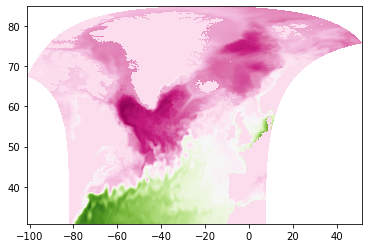

In [13]:
# Make a plot of the SSH map
fig, ax = plt.subplots()
ax.pcolormesh(glamt[1:imt-2,1:jmt-2],gphit[1:imt-2,1:jmt-2],ssh[1:imt-2,1:jmt-2], cmap=cmap)

In [18]:
for i in range(1,40):
    print(str(i))


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
